# Домашнее задание «Обучение сверточной сети на практике»

Классификация изображений: Cats vs Dogs
Обучить модель классификации изображение на 2 класса. Исходные данные и валидация решения на [kaggle](https://https://github.com/a4tunado/lectures/tree/master/006) в рамках контеста Cats vs Dogs . Шаблон ipython-ноутбука для решения можно скачать по [ссылке](https://https://github.com/a4tunado/lectures/tree/master/006). Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. Задание засчитывается при значениях метрики Log Loss меньше 0.3.
[Датасет](https://https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)

## Подключение библиотек

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import vgg19
from tensorflow.keras.applications import resnet


print(tf.__version__)
print(tf.executing_eagerly())

## Загрузка данных

In [ ]:
!unzip '/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip'
!unzip '/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip'

In [ ]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('/kaggle/working/train/*.jpg')
test_files = glob('/kaggle/working/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=32):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)

# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

In [ ]:
len(train_files)

25000

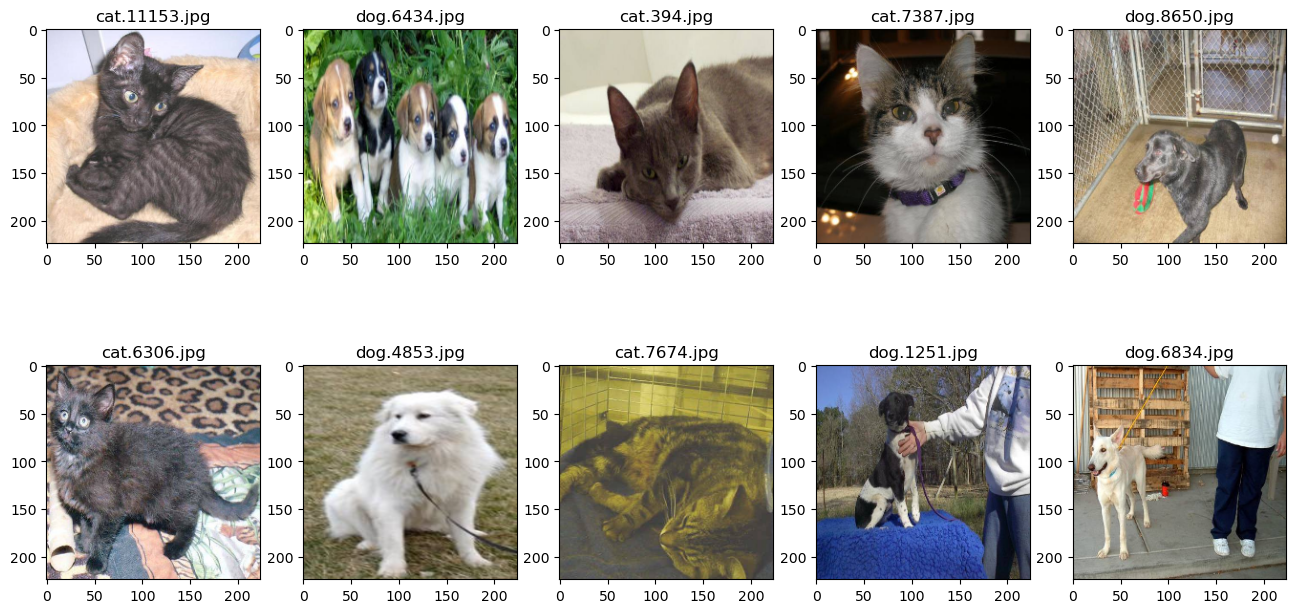

In [ ]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Загрузка предобученной модели

In [ ]:
# base_model - объект класса keras.models.Model (Functional Model)
base_model = resnet.ResNet50(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

## Добавление слоев, изменение модели

In [ ]:
from keras.constraints import maxnorm

In [ ]:
# Resnet фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='valid')(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.BatchNormalization(axis=1)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')

In [ ]:
model.summary()

Model: "dogs_vs_cats"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                       

## Компиляция и обучение измененной модели

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [ ]:
# новый
val_samples = 5000  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=30,  # число вызовов генератора за эпоху
          epochs=50,  # число эпох обучения
          verbose = 2,
          validation_data=validation_data)

Epoch 1/50
30/30 - 35s - loss: 0.1395 - accuracy: 0.9427 - val_loss: 0.1316 - val_accuracy: 0.9726 - 35s/epoch - 1s/step
Epoch 2/50
30/30 - 15s - loss: 0.1256 - accuracy: 0.9625 - val_loss: 0.0703 - val_accuracy: 0.9808 - 15s/epoch - 492ms/step
Epoch 3/50
30/30 - 16s - loss: 0.0708 - accuracy: 0.9750 - val_loss: 0.0857 - val_accuracy: 0.9780 - 16s/epoch - 525ms/step
Epoch 4/50
30/30 - 16s - loss: 0.1061 - accuracy: 0.9667 - val_loss: 0.0732 - val_accuracy: 0.9786 - 16s/epoch - 524ms/step
Epoch 5/50
30/30 - 16s - loss: 0.1170 - accuracy: 0.9635 - val_loss: 0.0892 - val_accuracy: 0.9772 - 16s/epoch - 526ms/step
Epoch 6/50
30/30 - 16s - loss: 0.0783 - accuracy: 0.9740 - val_loss: 0.0763 - val_accuracy: 0.9786 - 16s/epoch - 524ms/step
Epoch 7/50
30/30 - 15s - loss: 0.0912 - accuracy: 0.9729 - val_loss: 0.0645 - val_accuracy: 0.9848 - 15s/epoch - 484ms/step
Epoch 8/50
30/30 - 16s - loss: 0.0570 - accuracy: 0.9875 - val_loss: 0.0643 - val_accuracy: 0.9822 - 16s/epoch - 523ms/step
Epoch 9/50


In [ ]:
model.save('cats-dogs-resnet.hdf5')

## Предсказания на тестовой выборке

In [ ]:
len(test_files)

12500

In [ ]:
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

12500/12500 [==============================] - 131s 11ms/step


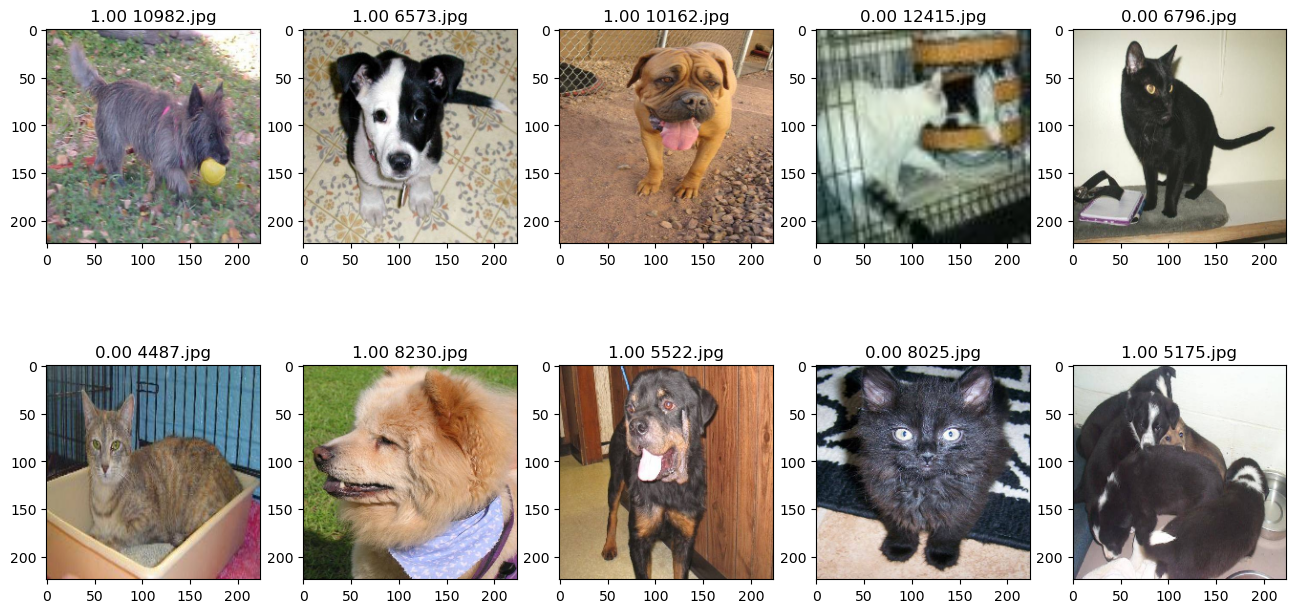

In [ ]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Сохранение предсказанных данных для отправки на kaggel

In [ ]:
import re

with open('submit.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))